In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time
import itertools
from math import factorial

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [3]:
def generateData(data, perm):
    n = data.shape[0]
    blockSize = n // len(perm)
    dataSet = np.zeros(data[0].shape)
    for i in perm:
        block = data[i*blockSize:(i+1)*blockSize]
#         print(block, end='\n\n')
        dataSet = np.vstack((dataSet, block))
    dataSet = dataSet[1:]
    return dataSet

In [4]:
# dataframe = read_csv('sp500.csv')
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)
print(data.shape)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039
(1259, 2)


In [5]:
# dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [15]:
split = 0.72
trainSize = int(len(data)*split)
testSize = len(data)-trainSize
print(trainSize)
print(testSize)

906
353


In [16]:
numInterval = 6
blockSize = trainSize//numInterval
print(blockSize)


151


In [17]:
    train = data[0:trainSize,:]
    test = data[trainSize:len(data),:]
    print(train[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [18]:
permutations = itertools.permutations(range(numInterval))
testBand = []
for perm in permutations:
    trainSet = generateData(train, perm)
    trainSet = np.reshape(trainSet, trainSet.shape)
    shuffleData = np.vstack((trainSet, test))

    lookBack = 3
    trainX, trainY = create_dataset(trainSet, lookBack)
    testX, testY = create_dataset(test, lookBack)

    # trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
    # testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

    units = 100
    drop = 0.2
    epoch = 10

    model = Sequential()
    model.add(LSTM(units, input_shape=(lookBack, 2)))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='nadam')
#     model.summary()
#     tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#     model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])
    model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1)

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

    trainPredictPlot = np.empty_like(shuffleData)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict

    testPredictPlot = np.empty_like(shuffleData)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(data)-1, :] = testPredict
    testBand.append(testPredict)
#     testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(data)-1, :] = testPredict

    col = 0
    testPlot = np.empty_like(trainSet)
    testPlot[:, :] = 0
    testPlot = np.vstack((testPlot, test))
#     plt.plot(scaler.inverse_transform(shuffleData)[:,col])
#     plt.plot(trainPredictPlot[:,col], color = 'orange')
#     plt.plot(testPredictPlot[:,col], color = 'green')
plt.plot(scaler.inverse_transform(testPlot)[:,col], color = 'blue')
plt.title('Epoch = %d Train = %.2f Test = %.2f' % (epoch, trainScore, testScore))

Epoch 1/1
902/902 [==============================] - 18s 20ms/step - loss: 0.0012
Train Score: 21.46 RMSE
Test Score: 39.50 RMSE
Epoch 1/1
902/902 [==============================] - 5s 6ms/step - loss: 0.0014
Train Score: 17.21 RMSE
Test Score: 13.76 RMSE
Epoch 1/1
902/902 [==============================] - 5s 6ms/step - loss: 0.0013
Train Score: 17.16 RMSE
Test Score: 21.05 RMSE
Epoch 1/1
902/902 [==============================] - 6s 6ms/step - loss: 9.3668e-04
Train Score: 15.08 RMSE
Test Score: 13.75 RMSE
Epoch 1/1
902/902 [==============================] - 6s 6ms/step - loss: 9.6481e-04
Train Score: 17.95 RMSE
Test Score: 15.23 RMSE
Epoch 1/1
902/902 [==============================] - 6s 6ms/step - loss: 0.0015
Train Score: 18.96 RMSE
Test Score: 22.91 RMSE
Epoch 1/1
902/902 [==============================] - 6s 6ms/step - loss: 0.0011
Train Score: 15.82 RMSE
Test Score: 25.87 RMSE
Epoch 1/1
902/902 [==============================] - 6s 6ms/step - loss: 0.0012
Train Score: 17.90 RM

902/902 [==============================] - 10s 11ms/step - loss: 0.0016
Train Score: 19.28 RMSE
Test Score: 13.75 RMSE
Epoch 1/1
902/902 [==============================] - 10s 11ms/step - loss: 0.0013
Train Score: 16.49 RMSE
Test Score: 17.94 RMSE
Epoch 1/1
902/902 [==============================] - 10s 11ms/step - loss: 0.0014
Train Score: 19.66 RMSE
Test Score: 15.83 RMSE
Epoch 1/1
902/902 [==============================] - 10s 11ms/step - loss: 0.0015
Train Score: 21.74 RMSE
Test Score: 18.57 RMSE
Epoch 1/1
902/902 [==============================] - 10s 12ms/step - loss: 0.0010
Train Score: 18.98 RMSE
Test Score: 17.22 RMSE
Epoch 1/1
902/902 [==============================] - 11s 12ms/step - loss: 0.0018
Train Score: 20.88 RMSE
Test Score: 15.28 RMSE
Epoch 1/1
902/902 [==============================] - 11s 12ms/step - loss: 0.0015
Train Score: 20.22 RMSE
Test Score: 15.16 RMSE
Epoch 1/1
902/902 [==============================] - 11s 12ms/step - loss: 0.0014
Train Score: 19.30 RMSE
T

KeyboardInterrupt: 

In [20]:
testBand = np.array(testBand)

In [21]:
# temp.shape

In [22]:
testBand = np.reshape(testBand, (testBand.shape))
# print(temp)

In [23]:
# temp[:,0,:]

In [24]:
print(np.mean(testBand[:,0,:], axis = 0))
print(np.std(testBand[:,0,:], axis = 0))

[396.00574 395.12387]
[1.7265694 2.095474 ]


In [15]:
z_alpha = 1.96
n = factorial(numInterval)

confInterval = []

for i in range(testBand.shape[1]):
    X = testBand[:, i, :]
    xBar = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    l = xBar - 1.96*s/(n**0,.5)
    r = xBar + 1.96*s/(n**0,.5)
    pair = [l, r]
    confInterval.append(pair)

In [16]:
# confInterval

[50 51 52 53 54 55 56 57 58 59 60]


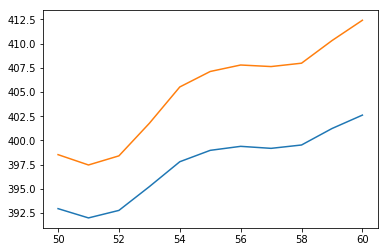

In [18]:
col = 0
offset = len(trainPredict)+(lookBack*2)+2
lower = []
upper = []
for i in range(len(confInterval)):
#     X = [i, i]
#     Y = [confInterval[i][0][0], confInterval[i][1][0]]
    lower.append(confInterval[i][0][0])
    upper.append(confInterval[i][1][0])
# XLower = np.array(range(offset+1, data.shape[0], blockSize//n))
# XUpper = np.array(range(offset+1, data.shape[0], blockSize//n))
XLower = np.array(range(offset+1, offset+1+testBand.shape[1]))
XUpper = np.array(range(offset+1, offset+1+testBand.shape[1]))
print(XLower)
# print(np.array(upper)+offset)
# plt.plot(lower, XLower)
# plt.plot(upper, XUpper)
plt.plot(XLower, lower)
plt.plot(XUpper, upper)
plt.show()

In [51]:
# np.array(range(offset+1, data.shape[0], blockSize//n))